/Users/seanchen/prj/scrapy_giant/crawler/spiders
(30, 130, 3)


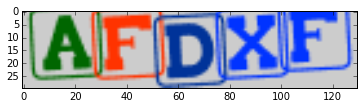

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import os
import cv
import numpy as np
import random

cwd = os.getcwd()
print cwd

# raw img display
image = cv2.imread("./train/otc_test0.png")
#print image
plt.imshow(image)
print image.shape

In [2]:
def resize(img, resize=1):
    # scalar must be int
    h,w = img.shape
    img = cv2.resize(img, (w*resize,h*resize), interpolation=cv2.INTER_CUBIC)
    return img

(120, 520)


True

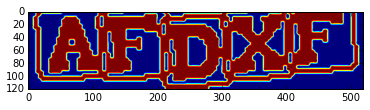

In [3]:
def normalize(img):
    img = cv2.cvtColor(img, cv2.CV_32F)
    # rgb 2 gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.equalizeHist(gray)
    ret,th0 = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    return th0

gray = resize(normalize(image), 2)
plt.imshow(gray)
print gray.shape     
cv2.imwrite("./train/otc_test_new_%0d.png" %(1), gray)


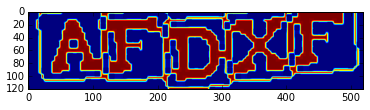

In [4]:
def erosion(img):
    # try to reduce noise boundary line
    kernel = np.ones((2,2),np.uint8)
    erosion = cv2.erode(img,kernel,iterations=5)
    return erosion

ersimg = erosion(gray)
plt.imshow(ersimg)

In [5]:
def dilation(img):
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations=2)
    return dilation

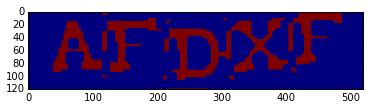

In [6]:
# ref
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
def bitwise_and_noise_reduce(img):  
    kernel = np.ones((1,1), np.uint8)
    # threshold filter
    ret,th1 = cv2.threshold(img, 235, 255, cv2.THRESH_BINARY)
    # colsing/opening
    open = cv2.morphologyEx(th1, cv2.MORPH_OPEN, kernel, iterations=5)
    close = cv2.morphologyEx(open, cv2.MORPH_CLOSE, kernel, iterations=5)
    mask = cv2.bitwise_and(th1, th1, mask=close)
    return mask

ff = bitwise_and_noise_reduce(ersimg)
plt.imshow(ff)

In [7]:
def iter_find_best_char_index(img, bund=1, limit=5):
    # feature select order by roll win area size
    h, w = img.shape
    area = lambda (x, y, w, h): (w*h, x, y, w, h)
    contours, hierarchy = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    
    best = sorted([area(cv2.boundingRect(cnt)) for cnt in contours], reverse=True)
    # iter sub captcha
    x0 = lambda x: x-bund if x > bund else 0
    y0 = lambda y: y-bund if y > bund else 0
    x1 = lambda x: x+bund if w-bund > x else w
    y1 = lambda y: y+bund if h-bund > y else h
    for it in sorted(best[:limit], key=lambda x: x[1]):
        yield ((x0(it[1]),y0(it[2])), (x1(it[1]+it[3]),y1(it[2]+it[4])))

In [8]:
def adjust_char_index(x, y, shape, direct='up', offset=3, max_x=35, max_y=35):
    x0, x1 = x
    y0, y1 = y
    h, w = shape
        
    if direct == 'up': 
        y0 = y0+offset
    elif direct == 'down':
        y0 = y0-offset
    elif direct == 'right':
        x0 = x0+offset
    elif direct == 'left':
        x0 = x0-offset
        
    x0 = max(x0, 1)
    y0 = max(y0, 1)
    x1 = max(min(x0+max_x, w-1), 1)
    y1 = max(min(y0+max_y, h-1), 1)
    
    return ((x0, y0), (x1, y1))    

In [9]:
def clone_img_to_blank(img, outer=4):
    h, w = img.shape
    bkimg = np.zeros((h+outer,w+outer,3), np.uint8)
    bkimg = cv2.cvtColor(bkimg, cv2.CV_32F)
    gray = cv2.cvtColor(bkimg, cv2.COLOR_RGB2GRAY)
    return gray   

In [10]:
def ini_img_as_blank(h, w):
    bkimg = np.zeros((h,w,3), np.uint8)
    bkimg = cv2.cvtColor(bkimg, cv2.CV_32F)
    gray = cv2.cvtColor(bkimg, cv2.COLOR_RGB2GRAY)
    return gray   

In [11]:
def blank_boundary_edge(img, outer=4):
    h, w = img.shape
    bh = h+outer*2
    bw = w+outer*2
    bkimg = ini_img_as_blank(bh,bw)
    bkimg[outer:h+outer,outer:w+outer] = img[0:h,0:w]
    ret,th0 = cv2.threshold(bkimg, 220, 255, cv2.THRESH_BINARY)
    return th0

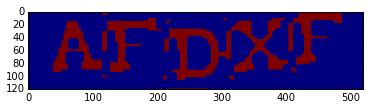

In [12]:
# try iter to clone feature to a new noe without noise
bkimg = clone_img_to_blank(gray, 0) 

tmpimg = gray
for i in range(1):
    tmpimg = bitwise_and_noise_reduce(erosion(tmpimg))
    
nwimg = tmpimg    
plt.imshow(tmpimg)

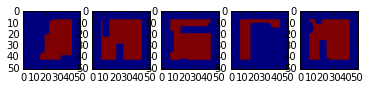

In [13]:
fig = plt.figure()
i =0

pic_v = []
# circular seqs
ADJUST_SEQS = [
    ('down', random.randint(0, 2)), 
    ('left', random.randint(4, 8)), 
    ('up',   random.randint(0, 2)),
    ('left', random.randint(4, 8)),
    ('down', random.randint(0, 2))
]

for bund in iter_find_best_char_index(nwimg, 1, 5):
    x,y = zip(*bund)
    args = (x, y, nwimg.shape, ADJUST_SEQS[i][0], ADJUST_SEQS[i][1])
    x,y = zip(*adjust_char_index(*args))
    ff = gray[y[0]:y[1],x[0]:x[1]]
    nwff = blank_boundary_edge(ff.copy(), 8)
    nwff = bitwise_and_noise_reduce(nwff)
    pic_v.append(nwff)
    a = fig.add_subplot(1, 5, i+1)
    plt.imshow(nwff)
    i+=1

In [14]:
import subprocess
import pytesser

test_txt = []
for pic in pic_v:
    txt = pytesser.iplimage_to_string(cv.fromarray(pic), 'eng', 10).strip()
    txt = txt.upper()
    test_txt.append(txt)
print test_txt    

['', '', '', 'F', '']
